# Analyse de l'influence des distributions des temps inter-véhiculaires sur un axe routier

Paramètres de simulation:
- 1 voie
- longueur de la voie : 15900 m
- présence d'outils de contrôle de la circulation : non
- paramètres de distribution 
    <br/> dn -> N(8.33, 1) [m]
    <br/> longueur -> N(7, 1) [m]
    <br/> vitesse -> N(14, 3) [m.s^-1]
    <br/> t -> N(2, 0.5) [s]
- durée de la simulation : 500 s = 5000 1/10s   
- seed pour reproductibilité : 45

import des librairies:

In [3]:
import numpy as np  
import network, simulation, toolkit
import makesimulation 
import matplotlib.pyplot as plt
import analysis
import statistics
import seaborn
from trafficintelligence import events, moving
import matplotlib.patches as mpatches

OpenCV library could not be loaded (video replay functions will not be available)
OpenCV library could not be loaded (video replay functions will not be available)


Récupération des fichiers initiaux

In [4]:
world = network.World.load('simple-net.yml')  
sim = simulation.Simulation.load('config.yml')


TypeError: list indices must be integers or slices, not str

- headways -> Exp(1.8, 1)
</br> On décalle la distribution à 1s % les temps inter-véhiculaires produits ne seront pas inférieurs à cette valeur

In [5]:
import numpy as np  
import network, simulation, toolkit
import makesimulation 
import matplotlib.pyplot as plt
import analysis
import statistics
import seaborn
from trafficintelligence import events, moving

world = network.World.load('simple-net.yml')  
sim = simulation.Simulation.load('config.yml')

seeds = [52,33]#0,110,2,45]
headways = [1.5, 1.8]#, 2, 2.4, 3]
interactions = {}
usersCount = {}
for seed in seeds : 
    usersCount[seed] = {}
    interactions[seed] = {}
    for h in headways:
    
        interactions[seed][h] = []
        world = network.World.load('simple-net.yml')  
        sim.seed = seed
        world.userInputs[0].distributions['headway'].scale = h-world.userInputs[0].distributions['headway'].loc
        
        world = makesimulation.run(world, sim)
        usersCount[seed][h] = world.getNotNoneVehiclesInWorld()
        for k in range(len(world.userInputs[0].alignment.users)-1):
            roadUser1 = world.userInputs[0].alignment.users[k]
            roadUser2 = world.userInputs[0].alignment.users[k+1]
            if roadUser1.timeInterval is not None and roadUser2.timeInterval is not None:
                i = events.Interaction(useCurvilinear=True, roadUser1=roadUser1, roadUser2=roadUser2)
                i.computeIndicators(world=world, alignment1=world.travelledAlignments(roadUser1), alignment2=world.travelledAlignments(roadUser2)) 
                interactions[seed][h].append(i)
toolkit.callWhenDone()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/trafficintelligence/events.py:238: RuntimeWarning: invalid value encountered in arccos
  collisionCourseDotProducts[instant] / (distances[instant] * speedDifferentials[instant]))


In [7]:
minDistanceList = {} # liste des distances minimales pour chaque simulation, pour chaque headway testé
minDistances = []
for h in headways:
    minDistanceList[h] = []
    for seed in seeds:
        for inter in interactions[seed][h]:
            minDistances.append(min(inter.indicators['Distance'].values.values()))
        minDistanceList[h].append(np.mean(minDistances))
        
data = [minDistanceList[x] for x in minDistanceList] 
plt.boxplot(data, vert=True, labels=headways) 
plt.xlabel('headway (s)')
plt.ylabel('average minimal interaction distance')
plt.show()        
##### OK ####

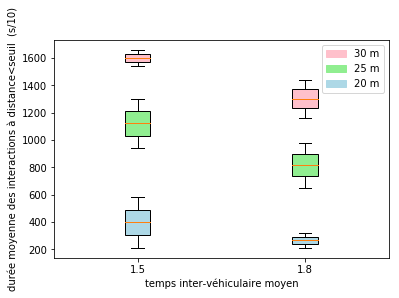

In [272]:
distances = [20, 25, 30]
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
# fig.num=0


duration = {} # liste des durees d'interactions pour chaque simulation, pour chaque headway testé
colors = ['lightblue', 'lightgreen', 'pink']
for col, distance in zip(colors, distances):    
    for h in headways:
        interactionDuration = []
        duration[h] = []
        for seed in seeds: 
            for inter in interactions[seed][h]:
                interactionDummies = []
                for t in list(inter.timeInterval):
                    if inter.indicators['Distance'].values[t] <= distance:#min(inter.indicators['Distance'].values.values()):
                        interactionDummies.append(1)
                    else:
                        interactionDummies.append(0)
                interactionDuration.append(sum(toolkit.makeSubListFromList(interactionDummies, 1)))
            duration[h].append(np.mean(interactionDuration))
    data = [duration[x] for x in duration]
    
    bp = plt.boxplot(data, vert=True, labels=headways, patch_artist=True)
    bp['boxes'][0].set_facecolor(col)
    bp['boxes'][1].set_facecolor(col)
    pink_patch = mpatches.Patch(color='pink', label='30 m')
    blue_patch =  mpatches.Patch(color='lightblue', label='20 m')
    green_patch = mpatches.Patch(color='lightgreen', label='25 m')
    plt.legend(handles=[pink_patch, green_patch, blue_patch])
    plt.ylabel('durée moyenne des interactions à distance<seuil  (s/10)')
    plt.xlabel('temps inter-véhiculaire moyen')
    
# plt.savefig('/home/lionel/projetmaitrise/outputData/average_duration_of_interactions.png')


RuntimeError: matplotlib does not support generators as input

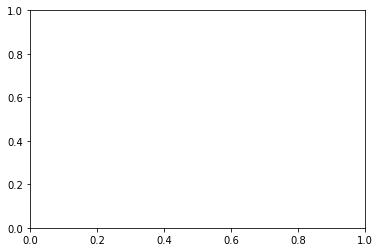

In [282]:
distances = [20, 25, 30]
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
# fig.num=0

colors = ['lightblue', 'lightgreen', 'pink']
proportion = {} # liste des proportions de temps ou deux vehicules sont tels que d=dmin, pour chaque simulation, pour chaque headway testé

for col, distance in zip(colors, distances):
    for h in headways:
        interactionDuration = []
        proportion[h] = []
        for seed in seeds: 
            for inter in interactions[seed][h]:
                interactionDummies = []
                for t in list(inter.timeInterval):
                    if inter.indicators['Distance'].values[t] <= distance:# min(inter.indicators['Distance'].values.values()):
                        interactionDummies.append(1)
                    else:
                        interactionDummies.append(0)
                interactionDuration.append(sum(toolkit.makeSubListFromList(interactionDummies, 1))/len(list(inter.timeInterval)))
            proportion[h].append(np.mean(interactionDuration))
            
    data = [proportion[x] for x in proportion] 
    
    # Make the histogram using a list of lists
    # Normalize the flights and assign colors and names
    plt.hist(x for x in data, label=distances)

    # Plot formatting
    plt.legend()
    plt.xlabel('temps inter-véhiculaire (s)')
    plt.ylabel('durée sous le seuil / durée de poursuite des vehicules (%)')
#     bp = plt.boxplot(data, vert=True, labels=headways, patch_artist=True) 
#     bp['boxes'][0].set_facecolor(col)
#     bp['boxes'][1].set_facecolor(col)
#     pink_patch = mpatches.Patch(color='pink', label='30 m')
#     blue_patch =  mpatches.Patch(color='lightblue', label='20 m')
#     green_patch = mpatches.Patch(color='lightgreen', label='25 m')
#     plt.legend(handles=[pink_patch, green_patch, blue_patch])
#     plt.xlabel('temps inter-véhiculaire (s)')
#     plt.ylabel('durée sous le seuil / durée de poursuite des vehicules (%)')
#     # plt.show()

# plt.savefig('/home/lionel/projetmaitrise/outputData/average_proportion_of_interaction_time_d=dmin.png')
# ### OK ###

In [95]:

count = {} # liste des nombre inter/nombre vehicles quand d<seuil, pour chaque simulation, pour chaque headway testé
distances = [20,25,30]
for distance in distances:
    for h in headways:
        interactionDuration = []
        count[h] = []
        for seed in seeds: 
            for inter in interactions[seed][h]:
                interactionDummies = []
                for t in list(inter.timeInterval):
                    if inter.indicators['Distance'].values[t] <= distance:# min(inter.indicators['Distance'].values.values()):
                        interactionDummies.append(1)
                    else:
                        interactionDummies.append(0)
                interactionDuration.append(toolkit.countElementInList(interactionDummies, 1))#/len(usersCount[seed][h][0]))
                # retirer les 0 du calcul des moyennes
#                 interactionDuration = list(filter(lambda x:x!=0, interactionDuration))
            count[h].append(np.mean(interactionDuration))
print(len(interactionDuration)            )
#     data = [np.mean(count[x]) for x in count] 
#     plt.plot(headways, data)
# #     plt.boxplot(data, vert=True, labels=headways)
#     plt.legend(distances)
#     plt.xlabel('headway (s)')
#     plt.ylabel('average proportion of interaction duration at distance < threshold  (%)')
    
    # plt.show()


317


In [70]:
seeds = [0,1]
headways = [1.5, 1.7]
distances = [k*5 for k in range(0, 10)]
count = {} # liste des nombre d'interactions / vehicles generes pour chaque simulation, pour chaque headway testé
for d in range(len(distances)-1):
    count[(distances[d], distances[d+1])] = {}
    for h in headways:
        count[(distances[d], distances[d+1])][h] = []
        for seed in seeds: 
            for inter in interactionsList[seed][h]:
                interactionNumber = []
                for t in list(inter.timeInterval):
                    if distances[d] < inter.indicators['Distance'].values[t] <= distances[d+1]:
                        interactionNumber.append(1)
                    else:
                        interactionNumber.append(0)
                interactionDuration.append(toolkit.countElementInList(interactionNumber, 1)/usersCount['number of generatedUsers']) 
            count[(distances[d], distances[d+1])][h].append(np.mean(interactionDuration))

NameError: name 'interactionsList' is not defined

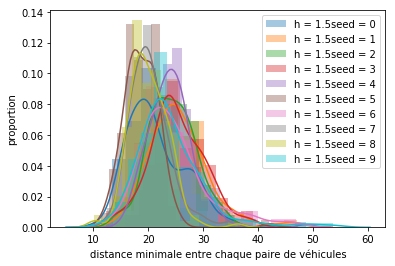

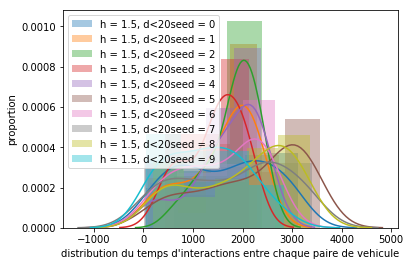

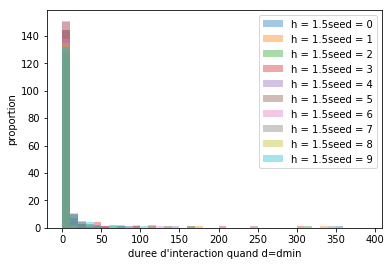

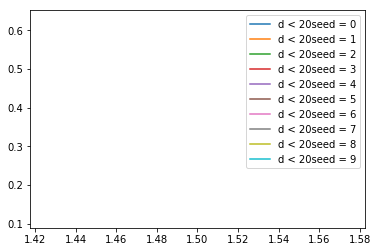

In [10]:
# liste des seeds a tester
seeds = [k for k in range(0,10)]#,47,48,49,50]

for seed in seeds:
    sim.seed = seed

    # liste des headways a essayer:
    headways = [1.5]#, 1.9, 2.3]#, 2.2, 2.3, 2.5]#, 1.6, 1.8, 2, 2.2]#, 2.4, 2.6, 2.8]
    cList = []
    fig0 = plt.figure(num=0)
    cList = {}
    durationList = {}
    durationList2 = {}
    count = {}
    
    for h in headways:
        # modification des paramètres dans simple-net.yml
        world = network.World.load('simple-net.yml')  
        world.userInputs[0].distributions['headway'].scale = h-world.userInputs[0].distributions['headway'].loc

        # running the simulation
        world = makesimulation.run(world, sim)
        
        # distribution des distances minimales d'interaction
        interactions = []
        # 1ere etape : recuperer la liste des interactions entre chaque paire de vehicules
        for k in range(len(world.userInputs[0].alignment.users)-1):
            roadUser1 = world.userInputs[0].alignment.users[k]
            roadUser2 = world.userInputs[0].alignment.users[k+1]
            if roadUser1.timeInterval is not None and roadUser2.timeInterval is not None:
                i = events.Interaction(useCurvilinear=True, roadUser1=roadUser1, roadUser2=roadUser2)
                i.computeIndicators(world=world, alignment1=world.travelledAlignments(roadUser1), alignment2=world.travelledAlignments(roadUser2)) 
                interactions.append(i)
        
        # recupérer la valeur minimale des distances entre chaque paire de vehicule 
        minDistances = [min(i.indicators['Distance'].values.values()) for i in interactions]
        plt.figure(num=0)
        ax = seaborn.distplot(minDistances, rug=False, hist=True, label='h = '+str(h)+'seed = '+str(seed), norm_hist=True)
        # pour chaque tiv testé on obtient la distribution des distances minimales entre chaque paire de véhicules
        plt.xlabel("distance minimale entre chaque paire de véhicules")
        plt.ylabel("proportion")
        ax.legend()
               
        minDistances = [20]#,25,30]
        cList[h] = {}
        
        for distance in minDistances:
            duration = []
            # rapport durée interaction
            for i in interactions:
                interactionLength = []
                for t in list(i.timeInterval):
                    if i.indicators['Distance'].values[t] < distance:
                        interactionLength.append(1)
                    else:
                        interactionLength.append(0)
                interactionDuration = sum(toolkit.makeSubListFromList(interactionLength, 1))
    #             interactionDuration = interactionDuration / len(list(i.timeInterval))
                duration.append(interactionDuration)
            durationList[h] = list(filter(lambda v: v !=0, duration))
            plt.figure(num=distance)
            ax=seaborn.distplot(durationList[h], rug=False, hist=True, label='h = '+str(h)+', d<'+str(distance)+'seed = '+str(seed), norm_hist=False)
            plt.xlabel("distribution du temps d'interactions entre chaque paire de vehicule")
            plt.ylabel("proportion")
            ax.legend()
            
        
        durationList2[h] = []
        # #############################################################333
        for i in interactions:
            duration2 = []
            interactionLength2 = []

            for t in list(i.timeInterval):

                if i.indicators['Distance'].values[t] == min(i.indicators['Distance'].values.values()):
                    interactionLength2.append(1)
                else:
                    interactionLength2.append(0)
        #     print(interactionLength2)
            interactionDuration2 = sum(toolkit.makeSubListFromList(interactionLength2, 1))
            durationList2[h].append(interactionDuration2)

        plt.figure('distance min')
        plt.hist(durationList2[h], label='h = '+str(h)+'seed = '+str(seed), density=False, bins=[k for k in range(0,400,10)], alpha=.4)
        plt.xlabel("duree d'interaction quand d=dmin")
        plt.ylabel("proportion")
        plt.legend()
        
        count[h] = {}
        for distance in minDistances:
            count[h][distance] = 0
            for i in interactions:
                interactionLength = []
                for t in list(i.timeInterval):
                    if i.indicators['Distance'].values[t] < distance:
                        interactionLength.append(1)
                    else:
                        interactionLength.append(0)
                count[h][distance] += toolkit.countElementInList(interactionLength, 1)
            count[h][distance] /= len(world.getNotNoneVehiclesInWorld()[0])
                
    count = toolkit.inverseDict(count, headways, minDistances)
    plt.figure('compte')
    for el in count:
        plt.plot(list(count[el].keys()), list(count[el].values()), label='d < '+str(el)+'seed = '+str(seed))
        plt.legend()
        

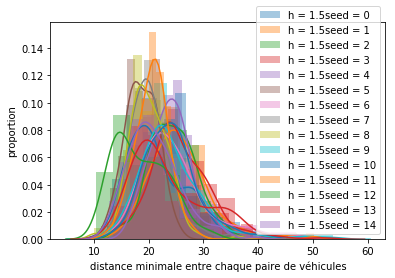

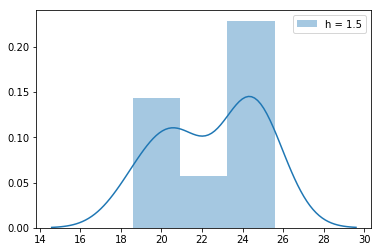

In [176]:
# liste des seeds a tester
seeds = [k for k in range(0,15)]#,47,48,49,50]
aTracer15 = []
for seed in seeds:
    sim.seed = seed

    # liste des headways a essayer:
    headways = [1.5]#, 1.9]#, 2.3]#, 2.2, 2.3, 2.5]#, 1.6, 1.8, 2, 2.2]#, 2.4, 2.6, 2.8]
    cList = []
    fig0 = plt.figure(num=0)
    cList = {}
    durationList = {}
    durationList2 = {}
    count = {}
    
    for h in headways:
        # modification des paramètres dans simple-net.yml
        world = network.World.load('simple-net.yml')  
        world.userInputs[0].distributions['headway'].scale = h-world.userInputs[0].distributions['headway'].loc

        # running the simulation
        world = makesimulation.run(world, sim)
        
        # distribution des distances minimales d'interaction
        interactions = []
        # 1ere etape : recuperer la liste des interactions entre chaque paire de vehicules
        for k in range(len(world.userInputs[0].alignment.users)-1):
            roadUser1 = world.userInputs[0].alignment.users[k]
            roadUser2 = world.userInputs[0].alignment.users[k+1]
            if roadUser1.timeInterval is not None and roadUser2.timeInterval is not None:
                i = events.Interaction(useCurvilinear=True, roadUser1=roadUser1, roadUser2=roadUser2)
                i.computeIndicators(world=world, alignment1=world.travelledAlignments(roadUser1), alignment2=world.travelledAlignments(roadUser2)) 
                interactions.append(i)
        
        # recupérer la valeur minimale des distances entre chaque paire de vehicule 
        minDistances = [min(i.indicators['Distance'].values.values()) for i in interactions]
        aTracer15.append(np.mean(minDistances))
        plt.figure(num=0)
        ax = seaborn.distplot(minDistances, rug=False, hist=True, label='h = '+str(h)+'seed = '+str(seed), norm_hist=False)
        # pour chaque tiv testé on obtient la distribution des distances minimales entre chaque paire de véhicules
        plt.xlabel("distance minimale entre chaque paire de véhicules")
        plt.ylabel("proportion")
        ax.legend()
plt.figure('je sais pas')
seaborn.distplot(aTracer15, label='h = '+str(h))
plt.legend()

# np.average(data, axis=1,

In [ ]:
headways = [1.5]
seed=[k for k in range(0,2)]

for seed in seeds : 
    for h in headways:
        world = network.World.load('simple-net.yml')  
        world.userInputs[0].distributions['headway'].scale = h-world.userInputs[0].distributions['headway'].loc

# running the simulation
        world = makesimulation.run(world, sim)

# distribution des distances minimales d'interaction
        interactions = []
# 1ere etape : recuperer la liste des interactions entre chaque paire de vehicules
        for k in range(len(world.userInputs[0].alignment.users)-1):
        roadUser1 = world.userInputs[0].alignment.users[k]
        roadUser2 = world.userInputs[0].alignment.users[k+1]
            if roadUser1.timeInterval is not None and roadUser2.timeInterval is not None:
            i = events.Interaction(useCurvilinear=True, roadUser1=roadUser1, roadUser2=roadUser2)
            i.computeIndicators(world=world, alignment1=world.travelledAlignments(roadUser1), alignment2=world.travelledAlignments(roadUser2)) 
            interactions.append(i)
            
            
        for i in interactions:
            duration2 = []
            interactionLength2 = []

            for t in list(i.timeInterval):

                if i.indicators['Distance'].values[t] == min(i.indicators['Distance'].values.values()):
                    interactionLength2.append(1)
                else:
                    interactionLength2.append(0)
        #     print(interactionLength2)
            interactionDuration2 = sum(toolkit.makeSubListFromList(interactionLength2, 1))
            durationList2[h].append(interactionDuration2)

        plt.figure('distance min')
        plt.hist(durationList2[h], label='h = '+str(h)+'seed = '+str(seed), density=False, bins=[k for k in range(0,400,10)], alpha=.4)
        plt.xlabel("duree d'interaction quand d=dmin")
        plt.ylabel("proportion")
        plt.legend()

seaborn.distplot(aTracer15, label='h = 1.5 s')
seaborn.distplot(aTracer19, label='h = 1.9 s')
seaborn.distplot(aTracer23, label='h = 2.3 s')
plt.xlabel("distance minimale d'interaction")
plt.ylabel('proportions')
plt.legend()